In [6]:
!pip install opencv-python matplotlib seaborn pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 22.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 33.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [7]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [8]:
IMAGE_DIR = "bin-images"        # folder containing .jpg files
META_DIR  = "metadata"      # folder containing .json files

In [49]:
def safe_get_value(field):
    if isinstance(field, dict):
        return field.get("value", None)
    return None

data = []

for meta_file in tqdm(os.listdir(META_DIR)):
    if not meta_file.endswith(".json"):
        continue
    
    meta_path = os.path.join(META_DIR, meta_file)
    with open(meta_path, 'r') as f:
        meta = json.load(f)

    image_id = meta_file.replace(".json", "")

    # Extract item dictionary
    item_dict = meta.get("BIN_FCSKU_DATA", {})

    for asin, item in item_dict.items():
        data.append({
            "image_id": image_id,
            "asin": asin,
            "name": item.get("name", None),
            "normalized_name": item.get("normalizedName", None),
            "quantity": item.get("quantity", None),
            "height": safe_get_value(item.get("height")),
            "width": safe_get_value(item.get("width")),
            "length": safe_get_value(item.get("length")),
            "weight": safe_get_value(item.get("weight")),
            "expected_total_qty": meta.get("EXPECTED_QUANTITY", None),
        })

df = pd.DataFrame(data)
df.head()


100%|██████████| 24999/24999 [00:04<00:00, 5597.62it/s]


,image_id,asin,name,normalized_name,quantity,height,width,length,weight,expected_total_qty
0,06933,B000MX14YQ,Moroso 74299 Mini Starter Heat Shield,Moroso 74299 Mini Starter Heat Shield,2,2.0,8.5,13.9,0.25,2
1,07621,B0058OWF5Q,Dunecraft Carol Cactus Science Kit,Dunecraft Carol Cactus Science Kit,1,2.3,2.8,2.8,0.30,3
2,07621,B01EIHW2OW,O'Neill men's Tech 24/7 long sleeve sun shirt ...,O'Neill men's Tech 24/7 long sleeve sun shirt ...,2,NaN,NaN,NaN,NaN,3
3,108928,B00A3QVB1S,"DecoArt Dimensional Effects, 4-Ounce","DecoArt Dimensional Effects, 4-Ounce",1,2.1,3.0,4.1,0.35,9
4,108928,B01F836UBQ,For Alcatel Onetouch Pixi GLITZ A463BG Soft TP...,For Alcatel Onetouch Pixi GLITZ A463BG Soft TP...,8,0.3,3.1,4.8,0.10,9


In [50]:
print("Total images:", len(os.listdir(IMAGE_DIR)))
print("Total metadata files:", len(os.listdir(META_DIR)))
print("Total item entries:", len(df))
print("Unique ASINs:", df["asin"].nunique())


Total images: 25000
Total metadata files: 24999
Total item entries: 66297
Unique ASINs: 38721


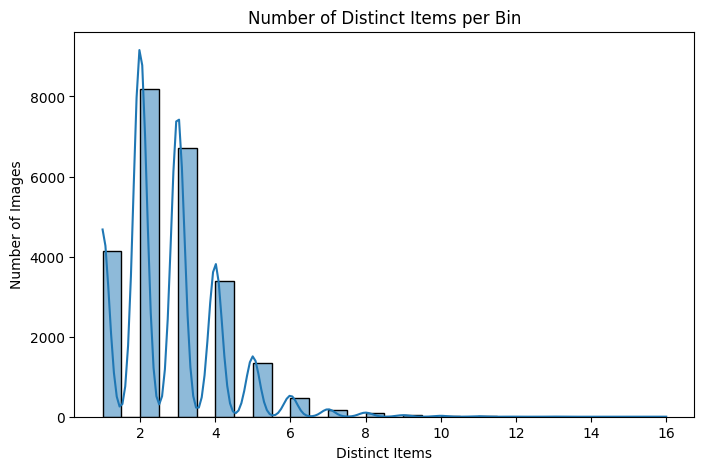

In [51]:
items_per_bin = df.groupby("image_id")["asin"].nunique()

plt.figure(figsize=(8,5))
sns.histplot(items_per_bin, bins=30, kde=True)
plt.title("Number of Distinct Items per Bin")
plt.xlabel("Distinct Items")
plt.ylabel("Number of Images")
plt.show()


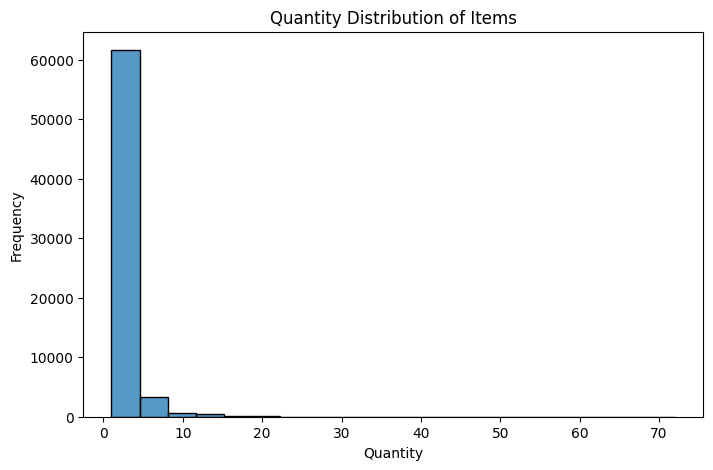

In [52]:
plt.figure(figsize=(8,5))
sns.histplot(df["quantity"], bins=20, kde=False)
plt.title("Quantity Distribution of Items")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.show()


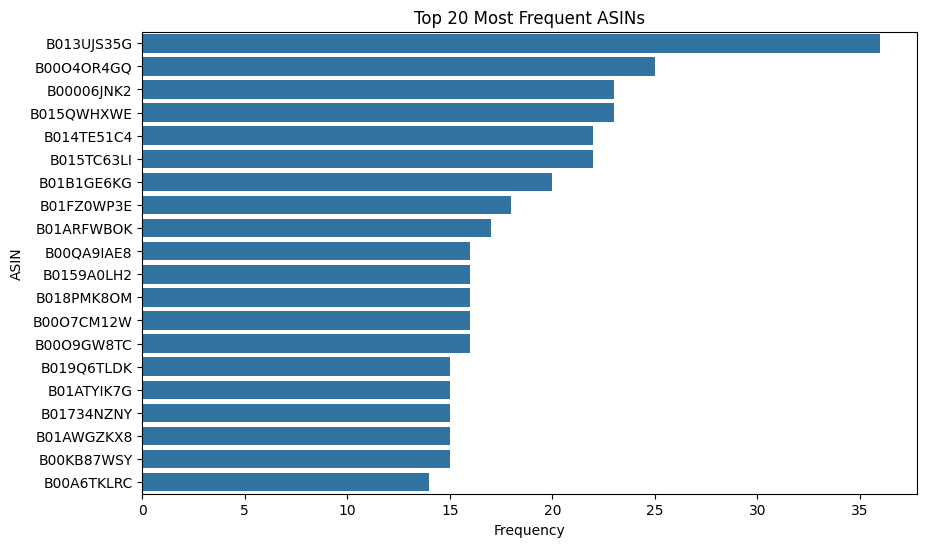

In [53]:
asin_counts = df["asin"].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=asin_counts.values, y=asin_counts.index)
plt.title("Top 20 Most Frequent ASINs")
plt.xlabel("Frequency")
plt.ylabel("ASIN")
plt.show()


In [54]:
widths, heights = [], []

for img_file in tqdm(os.listdir(IMAGE_DIR)):
    if not img_file.endswith(".jpg"):
        continue
    
    img_path = os.path.join(IMAGE_DIR, img_file)
    img = cv2.imread(img_path)
    
    if img is None:
        continue
        
    h, w = img.shape[:2]
    heights.append(h)
    widths.append(w)

df_img_res = pd.DataFrame({"width": widths, "height": heights})
df_img_res.describe()


100%|██████████| 25000/25000 [00:32<00:00, 766.24it/s]


,width,height
count,25000.000000,25000.00000
mean,475.295520,420.25460
std,106.517192,177.70756
min,295.000000,228.00000
25%,383.000000,281.00000
50%,449.000000,338.00000
75%,551.000000,551.00000
max,1182.000000,1179.00000


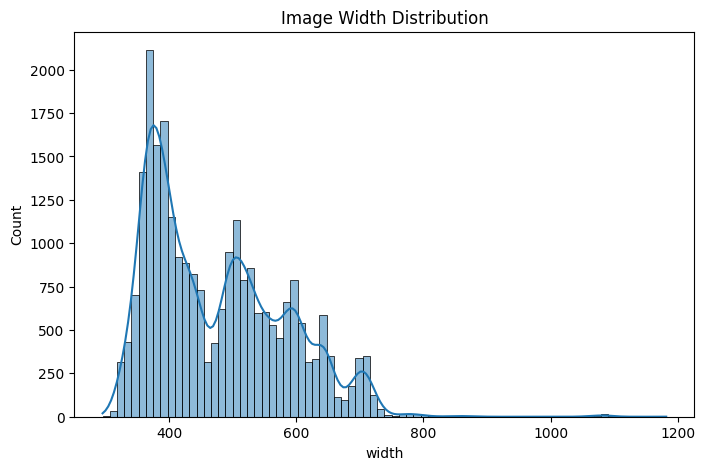

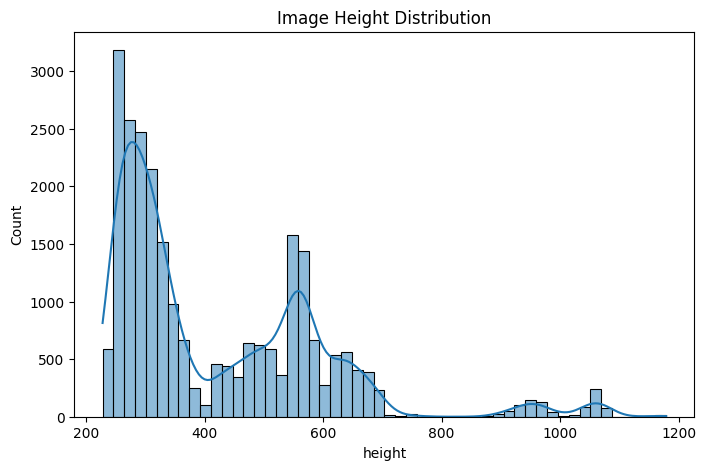

In [55]:
plt.figure(figsize=(8,5))
sns.histplot(df_img_res["width"], kde=True)
plt.title("Image Width Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df_img_res["height"], kde=True)
plt.title("Image Height Distribution")
plt.show()


In [56]:
all_images = set([f.replace(".jpg","") for f in os.listdir(IMAGE_DIR)])
all_meta   = set([f.replace(".json","") for f in os.listdir(META_DIR)])

missing_metadata = all_images - all_meta
missing_images   = all_meta - all_images

print("Images without metadata:", len(missing_metadata))
print("Metadata without images:", len(missing_images))


Images without metadata: 2
Metadata without images: 1


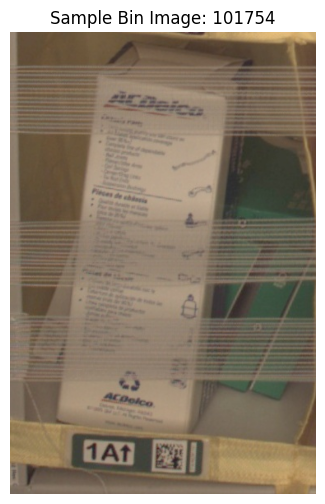

,image_id,asin,name,normalized_name,quantity,height,width,length,weight,expected_total_qty
18287,101754,B00006IF5K,"Scotch Magic Tape, 3/4 x 2592 Inches (810)","Scotch Magic Tape, 3/4 x 2592 Inches (810)",6,0.799213,4.799213,4.799213,0.250004,9
18288,101754,B001KSG2GW,ACDelco 45A1115 Professional Passenger Side Ou...,ACDelco 45A1115 Professional Passenger Side Ou...,1,2.800000,3.700000,10.500000,1.450000,9
18289,101754,B00PSMJ2MM,"JuSp, White Galaxy S4 Waterproof Case, Best Pr...","JuSp, White Galaxy S4 Waterproof Case, Best Pr...",2,1.000000,4.800000,8.800000,0.150000,9


In [57]:
import random

sample = random.choice(list(all_images))
img = cv2.imread(os.path.join(IMAGE_DIR, sample + ".jpg"))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Sample Bin Image: {sample}")
plt.show()

df[df["image_id"] == sample]


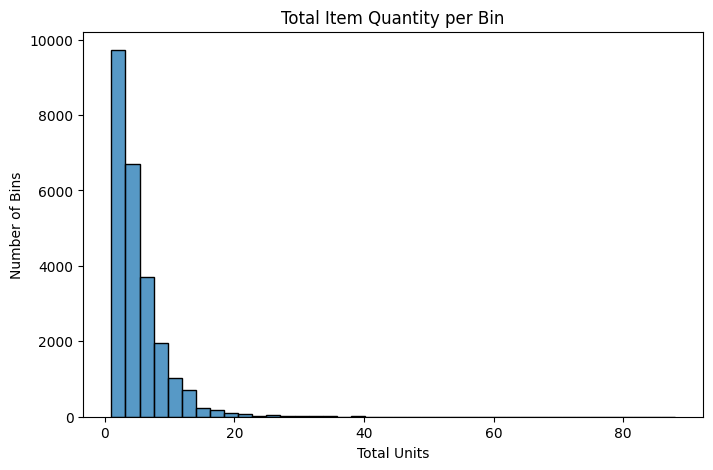

In [58]:
bins = df.groupby("image_id")["quantity"].sum()

plt.figure(figsize=(8,5))
sns.histplot(bins, bins=40, kde=False)
plt.title("Total Item Quantity per Bin")
plt.xlabel("Total Units")
plt.ylabel("Number of Bins")
plt.show()
